In [13]:
import pathlib
import os
import cv2
import pandas as pd
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np

In [2]:
original_dataset_path = "/home/alalbiol/Data/mamo/ddsm_yolo"
dest_dataset_path = "/home/alalbiol/Data/mamo/ddsm_yolo_patches"


In [3]:
def read_annotations(annotations_file):
    annotations = []
    with open(annotations_file, 'r') as f:
        for line in f:
            fields = line.strip().split()
            annotations.append(fields)
    return annotations


def get_number_of_annotations(label_path):
    """
    Get the number of annotations in a label file
    """
    
    with open(label_path, 'r') as f:
        return len(f.readlines())
    

In [45]:


original_dataset_path = pathlib.Path(original_dataset_path)
dest_dataset_path = pathlib.Path(dest_dataset_path)


crop_size = 640
all_annotations = []
for partition in ['training', 'validation']:
    orig_images_folder = original_dataset_path / partition / 'images'
    orig_labels_folder = original_dataset_path / partition / 'labels'
    dest_images_folder = dest_dataset_path / partition / 'images'
    dest_labels_folder = dest_dataset_path / partition / 'labels'
    
    pathlib.Path(dest_images_folder).mkdir(parents=True, exist_ok=True)
    pathlib.Path(dest_labels_folder).mkdir(parents=True, exist_ok=True)
    
    num_discarded = 0
    num_selected = 0
    
    num_patches = 0
    
    print(f"Processing {partition} partition: {orig_images_folder} -> {dest_images_folder}")
    all_images = list(orig_images_folder.glob('*.png'))
    for k, image_path in tqdm(enumerate(all_images)):
        label_path = orig_labels_folder / (image_path.stem + '.txt')
        if label_path.exists() and get_number_of_annotations(label_path) > 0:
            
            img = cv2.imread(str(image_path))
            im_width, im_height = img.shape[1], img.shape[0]
            annotations = read_annotations(label_path)
            
            num_annotations = len(annotations)
            
            for annotation in annotations:
                annotation_dict = {}
                annotation_image = image_path
                annotation_dict['partition'] = partition
                annotation_dict['image_id'] = annotation_image.stem
                annotation_dict['image'] = str(annotation_image)
                annotation_dict['class'] = int(annotation[0])
                annotation_dict['yolo_xcenter'] = float(annotation[1])
                annotation_dict['yolo_ycenter'] = float(annotation[2])
                annotation_dict['yolo_width'] = float(annotation[3])
                annotation_dict['yolo_height'] = float(annotation[4])
                annotation_dict['xcenter'] = int(float(annotation[1]) * im_width)
                annotation_dict['ycenter'] = int(float(annotation[2]) * im_height)
                annotation_dict['width'] = int(float(annotation[3]) * im_width)
                annotation_dict['height'] = int(float(annotation[4]) * im_height)
                annotation_dict['xmin'] = int(annotation_dict['xcenter'] - annotation_dict['width'] / 2)
                annotation_dict['ymin'] = int(annotation_dict['ycenter'] - annotation_dict['height'] / 2)
                annotation_dict['xmax'] = int(annotation_dict['xcenter'] + annotation_dict['width'] / 2)
                annotation_dict['ymax'] = int(annotation_dict['ycenter'] + annotation_dict['height'] / 2)
                
                crop_xmin = max(0, annotation_dict['xcenter']-crop_size//2)
                crop_xmax = min(im_width, annotation_dict['xcenter']+crop_size//2)
                if crop_xmin == 0:
                    crop_xmax = crop_size
                if crop_xmax == im_width:
                    crop_xmin = im_width - crop_size
                crop_ymin = max(0, annotation_dict['ycenter']-crop_size//2)
                crop_ymax = min(im_height, annotation_dict['ycenter']+crop_size//2)
                if crop_ymin == 0:
                    crop_ymax = crop_size
                if crop_ymax == im_height:
                    crop_ymin = im_height - crop_size
                
                
                annotation_dict['crop_xmin'] = crop_xmin
                annotation_dict['crop_ymin'] = crop_ymin
                annotation_dict['crop_xmax'] = crop_xmax
                annotation_dict['crop_ymax'] = crop_ymax
                annotation_dict['num_annotations'] = num_annotations
                
                
                
                all_annotations.append(annotation_dict)
                        
            dest_image_path = dest_images_folder / image_path.name
            dest_label_path = dest_labels_folder / label_path.name
            num_selected += 1
        else:
            num_discarded += 1
    

all_annotations_df = pd.DataFrame(all_annotations)

Processing training partition: /home/alalbiol/Data/mamo/ddsm_yolo/training/images -> /home/alalbiol/Data/mamo/ddsm_yolo_patches/training/images


8308it [01:45, 78.77it/s] 


Processing validation partition: /home/alalbiol/Data/mamo/ddsm_yolo/validation/images -> /home/alalbiol/Data/mamo/ddsm_yolo_patches/validation/images


2084it [00:25, 82.05it/s] 


In [51]:
all_annotations_df

,partition,image_id,image,class,yolo_xcenter,yolo_ycenter,yolo_width,yolo_height,xcenter,ycenter,...,height,xmin,ymin,xmax,ymax,crop_xmin,crop_ymin,crop_xmax,crop_ymax,num_annotations
0,training,A_1820_1.LEFT_CC,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,1,0.496057,0.330515,0.111894,0.083563,841,698,...,176,746,610,935,786,521,378,1161,1018,1
1,training,C_0165_1.LEFT_CC,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,1,0.233594,0.340454,0.124902,0.114987,396,719,...,242,290,598,501,840,76,399,716,1039,1
2,training,A_1393_1.LEFT_MLO,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,0,0.487590,0.574759,0.118156,0.128392,826,1213,...,271,726,1077,926,1348,506,893,1146,1533,1
3,training,A_1756_1.LEFT_CC,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,0,0.544967,0.552905,0.134484,0.125478,924,1167,...,265,810,1034,1038,1299,604,847,1244,1487,1
4,training,C_0438_1.RIGHT_MLO,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,0,0.487717,0.688277,0.175014,0.204485,827,1453,...,431,679,1237,975,1668,507,1133,1147,1773,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4635,validation,D_4072_1.LEFT_MLO,/home/alalbiol/Data/mamo/ddsm_yolo/validation/...,0,0.087859,0.492388,0.102887,0.094504,149,1039,...,199,62,939,236,1138,0,719,640,1359,1
4636,validation,B_3399_1.RIGHT_CC,/home/alalbiol/Data/mamo/ddsm_yolo/validation/...,1,0.736553,0.685613,0.141836,0.099689,1249,1448,...,210,1129,1343,1369,1553,929,1128,1569,1768,1
4637,validation,D_4188_1.LEFT_MLO,/home/alalbiol/Data/mamo/ddsm_yolo/validation/...,1,0.213500,0.823990,0.127654,0.086213,362,1740,...,182,254,1649,470,1831,42,1420,682,2060,1
4638,validation,D_4069_1.LEFT_CC,/home/alalbiol/Data/mamo/ddsm_yolo/validation/...,0,0.275386,0.365482,0.180567,0.152946,467,771,...,323,314,609,620,932,147,451,787,1091,1


In [52]:
all_annotations_df.loc[all_annotations_df['num_annotations'] == 3].head(10)

,partition,image_id,image,class,yolo_xcenter,yolo_ycenter,yolo_width,yolo_height,xcenter,ycenter,...,height,xmin,ymin,xmax,ymax,crop_xmin,crop_ymin,crop_xmax,crop_ymax,num_annotations
67,training,B_3029_1.LEFT_CC,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,0,0.045299,0.170471,0.055292,0.038695,76,360,...,81,29,319,122,400,0,40,640,680,3
68,training,B_3029_1.LEFT_CC,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,1,0.041746,0.202479,0.080162,0.037090,70,427,...,78,2,388,137,466,0,107,640,747,3
69,training,B_3029_1.LEFT_CC,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,1,0.190079,0.254636,0.192077,0.101462,322,537,...,214,159,430,484,644,2,217,642,857,3
204,training,B_3178_1.RIGHT_CC,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,0,0.335353,0.457018,0.024305,0.047588,568,965,...,100,547,915,588,1015,248,645,888,1285,3
205,training,B_3178_1.RIGHT_CC,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,0,0.385601,0.655263,0.019935,0.019518,653,1383,...,41,636,1362,669,1403,333,1063,973,1703,3
206,training,B_3178_1.RIGHT_CC,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,0,0.517776,0.590351,0.017751,0.019518,878,1246,...,41,863,1225,893,1266,558,926,1198,1566,3
269,training,B_3449_1.RIGHT_MLO,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,0,0.570197,0.504480,0.024828,0.016353,967,1065,...,34,946,1048,988,1082,647,745,1287,1385,3
270,training,B_3449_1.RIGHT_MLO,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,0,0.540069,0.596774,0.018132,0.021729,915,1260,...,45,900,1237,930,1282,595,940,1235,1580,3
271,training,B_3449_1.RIGHT_MLO,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,0,0.458612,0.612007,0.020364,0.019937,777,1292,...,42,760,1271,794,1313,457,972,1097,1612,3
359,training,B_3161_1.LEFT_CC,/home/alalbiol/Data/mamo/ddsm_yolo/training/im...,0,0.445990,0.429947,0.037348,0.026489,756,908,...,55,724,880,787,935,436,588,1076,1228,3


In [53]:
def visualize(image, bboxes,  category, format='yolo'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))  
    ax.imshow(image)
    img_width, img_height = image.shape[1], image.shape[0]
    if isinstance(bboxes, list):
        bboxes = np.array(bboxes)
    for k in range(bboxes.shape[0]):
        if format == 'yolo':
            xc, yc, w, h = bboxes[k]
            xc = xc * img_width
            yc = yc * img_height
            w = w * img_width
            h = h * img_height
            x = xc - w / 2
            y = yc - h / 2
        else:
            x, y, w, h = bboxes[k]
        rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
        ax.add_patch(rect)
    plt.show()
    

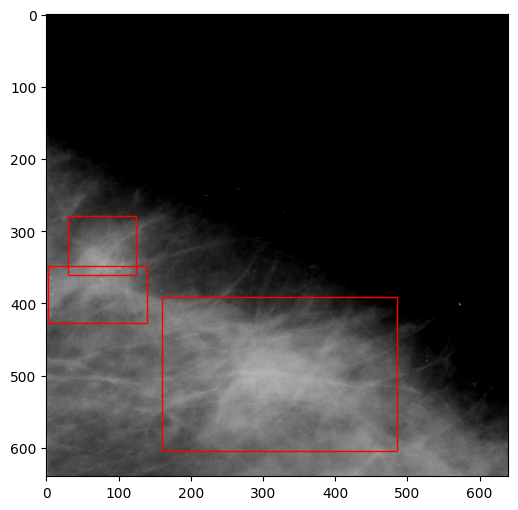

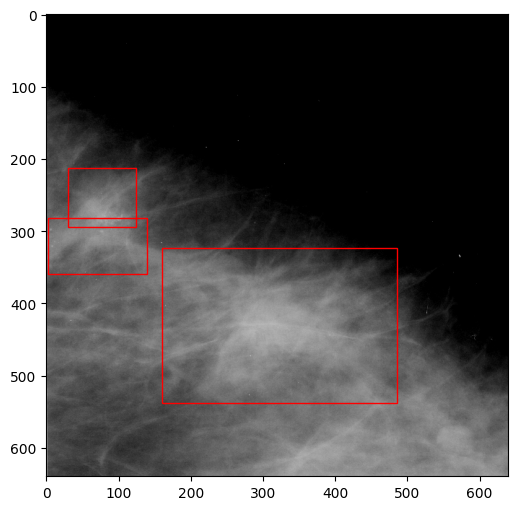

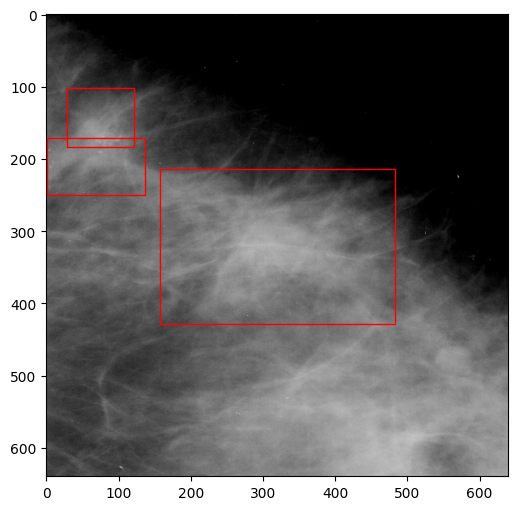

In [59]:
def extract_crop(annotation,df, visualize=False):
    """ Annotation """
    
    id = annotation['image_id']
    
    annot_image = df.loc[df['image_id'] == id]
    
    bboxes = annot_image[['yolo_xcenter', 'yolo_ycenter', 'yolo_width', 'yolo_height']].values
    labels = annot_image['class'].values
    
    img = cv2.imread(annotation['image'])
    
    transform = A.Compose([
        A.Crop(x_min=annotation['crop_xmin'], y_min=annotation['crop_ymin'], x_max=annotation['crop_xmax'], y_max=annotation['crop_ymax']),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels'], min_visibility=0.1))
    
    img_out = transform(image=img, bboxes=bboxes, labels=labels)
    visualize(img_out['image'], img_out['bboxes'], img_out['labels'], format='yolo')
    
  

annotations = all_annotations_df.loc[all_annotations_df['num_annotations'] == 3]
id = annotations['image_id'].values[0]
annotations = all_annotations_df.loc[all_annotations_df['image_id'] == id]

for idx, annotation in annotations.iterrows():
    extract_crop(annotation,all_annotations_df)

[[ 29 319  93  81]
 [  2 388 135  78]
 [159 430 325 214]]


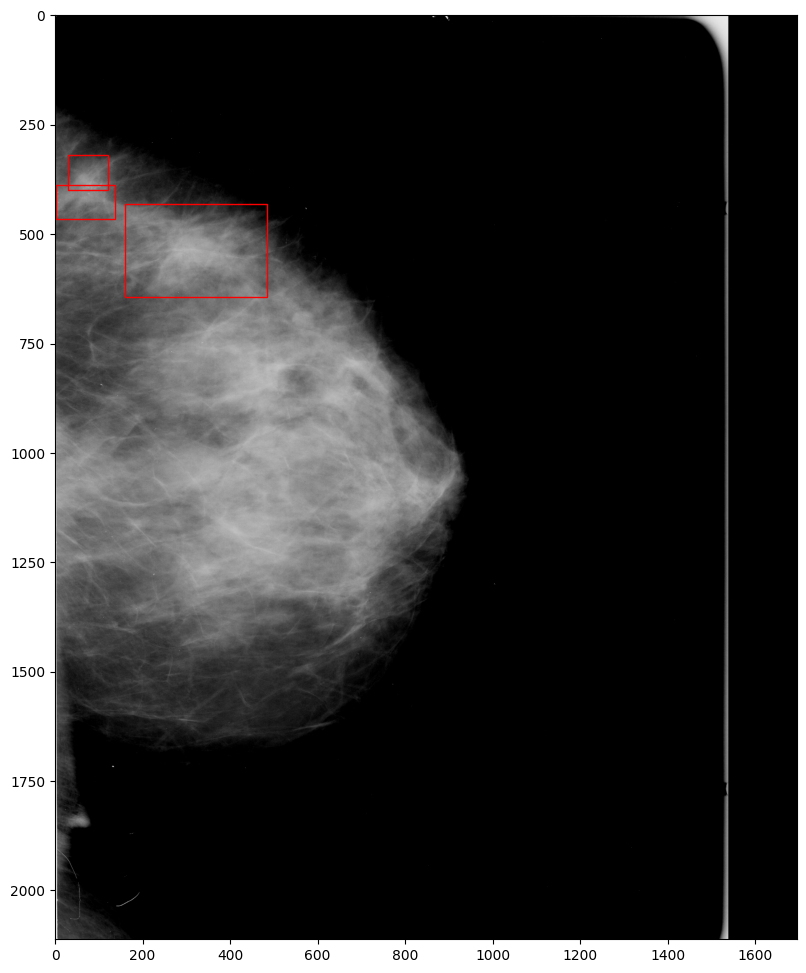

In [22]:
sample = all_annotations_df.loc[all_annotations_df['num_annotations'] == 3].iloc[0]
sample_id = sample['image_id']
annotations_sample = all_annotations_df[all_annotations_df['image_id'] == sample_id]

boxes = annotations_sample[['xmin', 'ymin', 'width', 'height']].values
print(boxes)
img = cv2.imread(sample['image'])   
visualize(img, boxes, annotations_sample['class'])

# Check dataset patches

In [69]:
import random
original_dataset_path = pathlib.Path("/home/alalbiol/Data/mamo/ddsm_yolo")
dest_dataset_path = pathlib.Path("/home/alalbiol/Data/mamo/ddsm_yolo_patches")

patch_images = list((dest_dataset_path / 'training' / 'images').glob('*.png'))
patch_labels = [pathlib.Path(str(p).replace('images', 'labels').replace('.png','.txt')) for p in patch_images]
patch_numpaches = [get_number_of_annotations(p) for p in patch_labels]

print("Num patch images:", len((patch_images)))

sample_patch = random.choice(patch_images)

print(sample_patch)

df = pd.DataFrame({'image': patch_images, 'label': patch_labels, 'numpatches': patch_numpaches})



Num patch images: 3755
/home/alalbiol/Data/mamo/ddsm_yolo_patches/training/images/C_0102_1.LEFT_MLO_0.png


In [90]:
def find_ddsm_image(image_path, original_dataset_path):
    stem = image_path.stem
    partition = image_path.parts[-3]
    new_stem = "_".join(stem.split('_')[:-1])
    ddsm_image_path = original_dataset_path / partition / 'images' / (new_stem + '.png')
    if not dest_dataset_path.exists():
        print(f"Image {image_path} not found in original dataset")
        return None
    
    
    return ddsm_image_path


print(find_ddsm_image(sample_patch, original_dataset_path))

find_ddsm_image(sample_patch, original_dataset_path)

df['ddsm_image'] = df['image'].apply(lambda x: find_ddsm_image(x, original_dataset_path))


/home/alalbiol/Data/mamo/ddsm_yolo/training/images/C_0102_1.LEFT_MLO.png


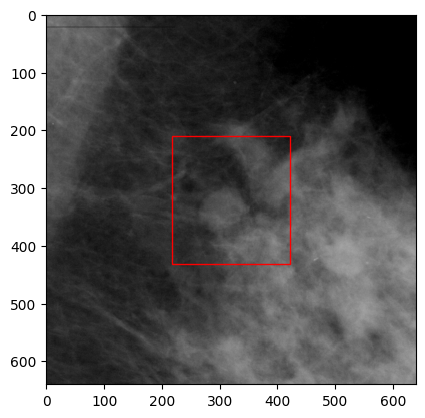

In [91]:
def visualize(image_path, ax):
    img = cv2.imread(str(image_path))
    ax.imshow(img)
    labels_path = pathlib.Path(str(image_path).replace('images', 'labels').replace('.png','.txt'))
    annotations = read_annotations(labels_path)
    for annotation in annotations:
        class_id, xcenter, ycenter, width, height = annotation
        xcenter, ycenter, width, height = float(xcenter), float(ycenter), float(width), float(height)
        xcenter = int(xcenter * img.shape[1])
        ycenter = int(ycenter * img.shape[0])
        width = int(width * img.shape[1])
        height = int(height * img.shape[0])
        x = xcenter - width // 2
        y = ycenter - height // 2
        rect = plt.Rectangle((x, y), width, height, fill=False, color='red')
        ax.add_patch(rect)
    
    
visualize(sample_patch, plt.gca())

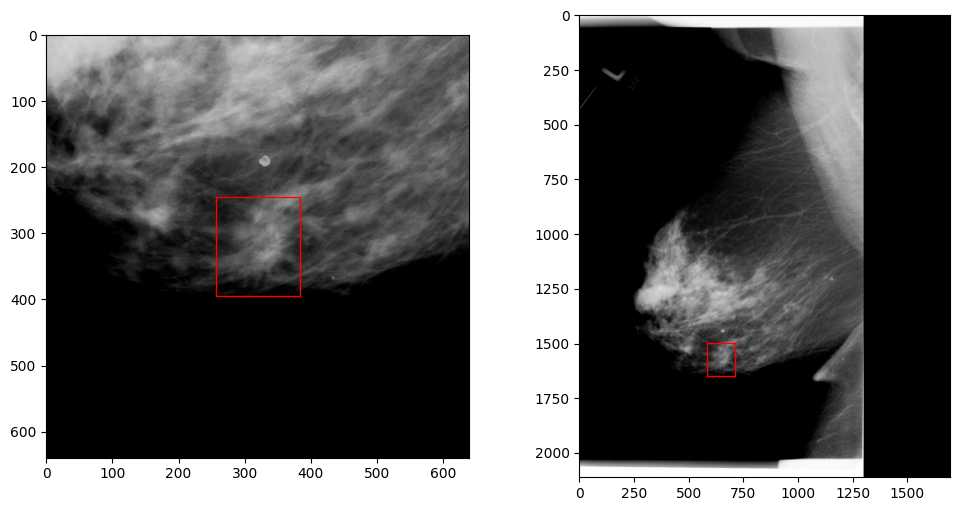

In [108]:
sample_df = df.sample(1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
visualize(sample_df['image'].values[0], ax[0])
visualize(sample_df['ddsm_image'].values[0], ax[1])

In [84]:
(sample_df['ddsm_image'].values[0])

PosixPath('/home/alalbiol/Data/mamo/ddsm_yolo/images/images/A_1889_1.RIGHT_CC.png')